In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objs as go

import boto3
import awswrangler as wr

import os
from dotenv import load_dotenv
from datetime import datetime

/Users/ernestsalim/Devs/Personal/stock-analysis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

AWS_ACCESS_KEY = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")

In [3]:
glue_db = "alpaca_stocks_database"
glue_monthly_table = f"stocks_table_{datetime.now().year}_{datetime.now().month}"
glue_historical_table = "stocks_table_historical"

In [4]:
boto3.setup_default_session(
    aws_access_key_id = AWS_ACCESS_KEY,
    aws_secret_access_key = AWS_SECRET_KEY,
    region_name = "us-west-1")

In [5]:
athena_query = f'''
    SELECT *
    FROM {glue_historical_table}
    ORDER BY timestamp ASC
'''

dataset = wr.athena.read_sql_query(athena_query, database = glue_db, ctas_approach = True)

In [6]:
dataset[dataset['symbol'] == 'GOOGL']

,symbol,high,low,open,timestamp,trade_count,volume,vwap,year,month,day
0,GOOGL,935.8200,920.8000,924.15,2017-05-01 04:00:00,37066.0,2327898.0,931.019108,2017,5,1
164,GOOGL,942.9850,931.0000,933.27,2017-05-02 04:00:00,31769.0,1751307.0,937.343320,2017,5,2
211,GOOGL,950.2000,935.2100,936.05,2017-05-03 04:00:00,31198.0,1833416.0,943.498472,2017,5,3
448,GOOGL,959.1400,947.3700,950.29,2017-05-04 04:00:00,32392.0,1938360.0,953.773606,2017,5,4
627,GOOGL,958.4395,948.0986,956.72,2017-05-05 04:00:00,27628.0,1615552.0,951.150919,2017,5,5
...,...,...,...,...,...,...,...,...,...,...,...
328596,GOOGL,118.0300,116.1100,116.68,2023-05-12 04:00:00,442728.0,40521731.0,117.054711,2023,5,12
328736,GOOGL,118.4800,116.0100,116.22,2023-05-15 04:00:00,394997.0,36292193.0,116.981253,2023,5,15
328798,GOOGL,120.7500,116.4300,116.49,2023-05-16 04:00:00,440291.0,45060525.0,119.335329,2023,5,16
329003,GOOGL,121.6700,118.8900,119.61,2023-05-17 04:00:00,316532.0,33336875.0,120.342901,2023,5,17


## Prophet Approach

In [7]:
def display_forecast(df, periods, plot_only=True):
    m = Prophet()
    m.add_country_holidays(country_name='US')

    df_train, df_test = df.iloc[0:1920], df.iloc[1920:]

    x = df_train[['timestamp', 'open']].rename(columns={'timestamp': 'ds', 'open': 'y'})
    x['ds'] = x['ds'].dt.strftime('%Y-%m-%d')

    y = df_test[['timestamp', 'open']].rename(columns={'timestamp': 'ds', 'open': 'y'})
    y['ds'] = y['ds'].dt.strftime('%Y-%m-%d')

    m.fit(x)
    future = m.make_future_dataframe(periods=periods)
    forecast = m.predict(future)
    plot = m.plot(forecast)
    
    return None if plot_only else (m, forecast)

21:01:08 - cmdstanpy - INFO - Chain [1] start processing
21:01:08 - cmdstanpy - INFO - Chain [1] done processing


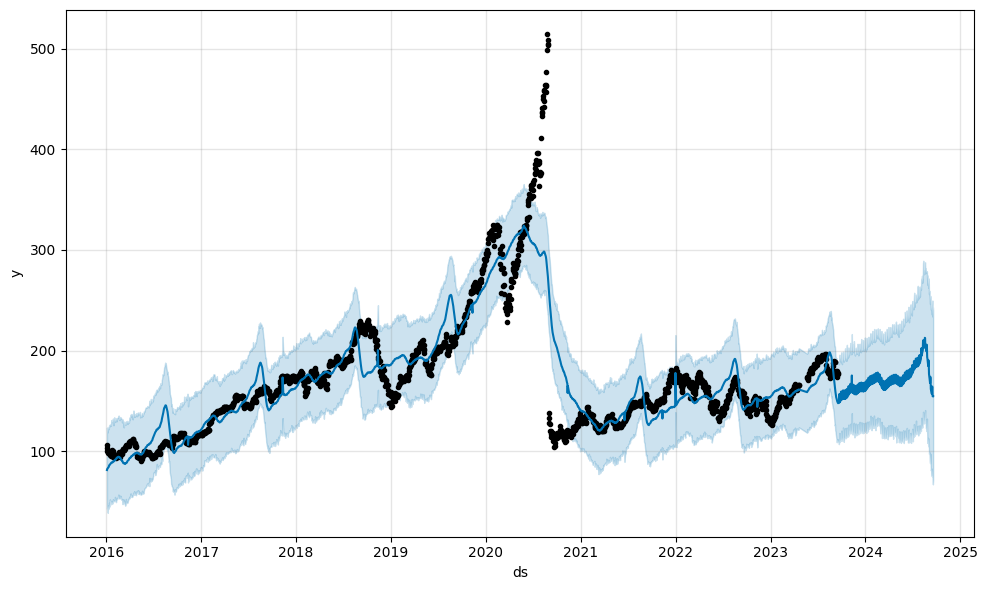

In [8]:
ticker = 'AAPL'
m, forecast = display_forecast(dataset[dataset['symbol'] == ticker], periods=365, plot_only=False)

In [9]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2280,2024-09-14,164.279029,82.525327,245.708609
2281,2024-09-15,163.627161,79.141161,249.746485
2282,2024-09-16,154.511433,71.100817,233.630007
2283,2024-09-17,154.774456,66.931024,243.096316
2284,2024-09-18,154.602850,71.296112,239.981978


In [12]:
fig = plot_plotly(m, forecast)
fig.write_html("../plot.html")

## LSTM Approach

In [86]:
dataset_train, dataset_test = dataset.iloc[0:1920], dataset.iloc[1920:]

training_set = dataset_train.iloc[:, 3:4].values

In [73]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [78]:
X_train = []
y_train = []

for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [80]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
59/59 [==============================] - 6s 44ms/step - loss: 0.0181
Epoch 2/100
59/59 [==============================] - 3s 45ms/step - loss: 0.0095
Epoch 3/100
59/59 [==============================] - 3s 48ms/step - loss: 0.0059
Epoch 4/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0057
Epoch 5/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0054
Epoch 6/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0047
Epoch 7/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0045
Epoch 8/100
59/59 [==============================] - 4s 60ms/step - loss: 0.0042
Epoch 9/100
59/59 [==============================] - 3s 49ms/step - loss: 0.0040
Epoch 10/100
59/59 [==============================] - 3s 49ms/step - loss: 0.0043
Epoch 11/100
59/59 [==============================] - 3s 53ms/step - loss: 0.0038
Epoch 12/100
59/59 [==============================] - 4s 63ms/step - loss: 0.0042
Epoch 13/100
59/59 [=====